In [1]:
import os
import torch
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer
from tqdm import tqdm
from util.util import calc_psnr as calc_psnr
import time
import numpy as np
from collections import OrderedDict as odict
from copy import deepcopy

In [75]:
! find . -name "__pycache__" -exec rm -rf {} +
! find . -name "*.pyc" -delete

10258.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
10263.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


# Using model for inference

## Network.py needs to be imported as a py file

## Base Model

In [2]:
import os
import torch
from collections import OrderedDict
from abc import ABC, abstractmethod
import networks
import torch
from util.util import torch_save
import math 
import torch.nn.functional as F


class BaseModel(ABC):
	def __init__(self, opt):
		self.opt = opt
		self.gpu_ids = opt.gpu_ids
		self.isTrain = opt.isTrain
		self.scale = opt.scale

		if len(self.gpu_ids) > 0:
			self.device = torch.device('cuda', self.gpu_ids[0])
		else:
			self.device = torch.device('cpu')
		self.save_dir = os.path.join(opt.checkpoints_dir, opt.name)
		self.loss_names = []
		self.model_names = []
		self.visual_names = []
		self.optimizers = []
		self.optimizer_names = []
		self.image_paths = []
		self.metric = 0  # used for learning rate policy 'plateau'
		self.start_epoch = 0
				
		self.backwarp_tenGrid = {}
		self.backwarp_tenPartial = {}

	@staticmethod
	def modify_commandline_options(parser, is_train):
		return parser

	@abstractmethod
	def set_input(self, input):
		pass

	@abstractmethod
	def forward(self):
		pass

	@abstractmethod
	def optimize_parameters(self):
		pass

	def setup(self, opt=None):
		opt = opt if opt is not None else self.opt
		if self.isTrain:
			self.schedulers = [get_scheduler(optimizer, opt) \
							   for optimizer in self.optimizers]
			for scheduler in self.schedulers:
				scheduler.last_epoch = opt.load_iter
		if opt.load_iter > 0 or opt.load_path != '':
			load_suffix = opt.load_iter
			self.load_networks(load_suffix)
			if opt.load_optimizers:
				self.load_optimizers(opt.load_iter)

		self.print_networks(opt.verbose)

	def eval(self):
		for name in self.model_names:
			net = getattr(self, 'net' + name)
			net.eval()

	def train(self):
		for name in self.model_names:
			net = getattr(self, 'net' + name)
			net.train()

	def test(self):
		with torch.no_grad():
			self.forward()

	def get_image_paths(self):
		return self.image_paths

	def update_learning_rate(self):
		for i, scheduler in enumerate(self.schedulers):
			if scheduler.__class__.__name__ == 'ReduceLROnPlateau':
				scheduler.step(self.metric)
			else:
				scheduler.step()
			print('lr of %s = %.7f' % (
					self.optimizer_names[i], scheduler.get_last_lr()[0]))

	def get_current_visuals(self):
		visual_ret = OrderedDict()
		for name in self.visual_names:
			if 'xy' in name or 'coord' in name:
				visual_ret[name] = getattr(self, name).detach()
			else:
				visual_ret[name] = torch.clamp(
							getattr(self, name).detach()*255, 0, 255).round()
		return visual_ret

	def get_current_losses(self):
		errors_ret = OrderedDict()
		for name in self.loss_names:
			errors_ret[name] = float(getattr(self, 'loss_' + name))
		return errors_ret

	def save_networks(self, epoch):
		for name in self.model_names:
			save_filename = '%s_model_%d.pth' % (name, epoch)
			save_path = os.path.join(self.save_dir, save_filename)
			net = getattr(self, 'net' + name)
			if self.device.type == 'cuda':
				state = {'state_dict': net.module.cpu().state_dict()}
				torch_save(state, save_path)
				net.to(self.device)
			else:
				state = {'state_dict': net.state_dict()}
				torch_save(state, save_path)
		self.save_optimizers(epoch)

	def load_networks(self, epoch):
		for name in self.model_names: #[0:1]:
			# if name is 'Discriminator':
			# 	continue
			load_filename = '%s_model_%d.pth' % (name, epoch)
			if self.opt.load_path != '':
				load_path = self.opt.load_path
			else:
				load_path = os.path.join(self.save_dir, load_filename)
			net = getattr(self, 'net' + name)
			if isinstance(net, torch.nn.DataParallel):
				net = net.module
			state_dict = torch.load(load_path, map_location=self.device)
			print('loading the model from %s' % (load_path))
			if hasattr(state_dict, '_metadata'):
				del state_dict._metadata

			net_state = net.state_dict()
			is_loaded = {n:False for n in net_state.keys()}
			for name, param in state_dict['state_dict'].items():
				if name in net_state:
					try:
						net_state[name].copy_(param)
						is_loaded[name] = True
					except Exception:
						print('While copying the parameter named [%s], '
							  'whose dimensions in the model are %s and '
							  'whose dimensions in the checkpoint are %s.'
							  % (name, list(net_state[name].shape),
								 list(param.shape)))
						raise RuntimeError
				else:
					print('Saved parameter named [%s] is skipped' % name)
			mark = True
			for name in is_loaded:
				if not is_loaded[name]:
					print('Parameter named [%s] is randomly initialized' % name)
					mark = False
			if mark:
				print('All parameters are initialized using [%s]' % load_path)

			self.start_epoch = epoch

	def save_optimizers(self, epoch):
		assert len(self.optimizers) == len(self.optimizer_names)
		for id, optimizer in enumerate(self.optimizers):
			save_filename = self.optimizer_names[id]
			state = {'name': save_filename,
					 'epoch': epoch,
					 'state_dict': optimizer.state_dict()}
			save_path = os.path.join(self.save_dir, save_filename+'.pth')
			torch_save(state, save_path)

	def load_optimizers(self, epoch):
		assert len(self.optimizers) == len(self.optimizer_names)
		for id, optimizer in enumerate(self.optimizer_names):
			load_filename = self.optimizer_names[id]
			load_path = os.path.join(self.save_dir, load_filename+'.pth')
			print('loading the optimizer from %s' % load_path)
			state_dict = torch.load(load_path)
			assert optimizer == state_dict['name']
			assert epoch == state_dict['epoch']
			self.optimizers[id].load_state_dict(state_dict['state_dict'])

	def print_networks(self, verbose):
		print('---------- Networks initialized -------------')
		for name in self.model_names:
			if isinstance(name, str):
				net = getattr(self, 'net' + name)
				num_params = 0
				for param in net.parameters():
					num_params += param.numel()
				if verbose:
					print(net)
				print('[Network %s] Total number of parameters : %.3f M'
					  % (name, num_params / 1e6))
		print('-----------------------------------------------')

	def set_requires_grad(self, nets, requires_grad=False):
		if not isinstance(nets, list):
			nets = [nets]
		for net in nets:
			if net is not None:
				for param in net.parameters():
					param.requires_grad = requires_grad

	def estimate(self, tenFirst, tenSecond, net):
		assert(tenFirst.shape[3] == tenSecond.shape[3])
		assert(tenFirst.shape[2] == tenSecond.shape[2])
		intWidth = tenFirst.shape[3]
		intHeight = tenFirst.shape[2]
		# tenPreprocessedFirst = tenFirst.view(1, 3, intHeight, intWidth)
		# tenPreprocessedSecond = tenSecond.view(1, 3, intHeight, intWidth)

		intPreprocessedWidth = int(math.floor(math.ceil(intWidth / 64.0) * 64.0))
		intPreprocessedHeight = int(math.floor(math.ceil(intHeight / 64.0) * 64.0))

		tenPreprocessedFirst = F.interpolate(input=tenFirst, 
								size=(intPreprocessedHeight, intPreprocessedWidth), 
								mode='bilinear', align_corners=False)
		tenPreprocessedSecond = F.interpolate(input=tenSecond, 
								size=(intPreprocessedHeight, intPreprocessedWidth), 
								mode='bilinear', align_corners=False)

		tenFlow = 20.0 * F.interpolate(
			             input=net(tenPreprocessedFirst, tenPreprocessedSecond), 
						 size=(intHeight, intWidth), mode='bilinear', align_corners=False)

		tenFlow[:, 0, :, :] *= float(intWidth) / float(intPreprocessedWidth)
		tenFlow[:, 1, :, :] *= float(intHeight) / float(intPreprocessedHeight)

		return tenFlow[:, :, :, :]
	
	def backwarp(self, tenInput, tenFlow):
		index = str(tenFlow.shape) + str(tenInput.device)
		if index not in self.backwarp_tenGrid:
			tenHor = torch.linspace(-1.0 + (1.0 / tenFlow.shape[3]), 1.0 - (1.0 / tenFlow.shape[3]), 
					 tenFlow.shape[3]).view(1, 1, 1, -1).expand(-1, -1, tenFlow.shape[2], -1)
			tenVer = torch.linspace(-1.0 + (1.0 / tenFlow.shape[2]), 1.0 - (1.0 / tenFlow.shape[2]), 
					 tenFlow.shape[2]).view(1, 1, -1, 1).expand(-1, -1, -1, tenFlow.shape[3])
			self.backwarp_tenGrid[index] = torch.cat([tenHor, tenVer], 1).to(tenInput.device)

		if index not in self.backwarp_tenPartial:
			self.backwarp_tenPartial[index] = tenFlow.new_ones([
				 tenFlow.shape[0], 1, tenFlow.shape[2], tenFlow.shape[3]])

		tenFlow = torch.cat([tenFlow[:, 0:1, :, :] / ((tenInput.shape[3] - 1.0) / 2.0), 
							 tenFlow[:, 1:2, :, :] / ((tenInput.shape[2] - 1.0) / 2.0)], 1)
		tenInput = torch.cat([tenInput, self.backwarp_tenPartial[index]], 1)

		tenOutput = F.grid_sample(input=tenInput, 
					grid=(self.backwarp_tenGrid[index] + tenFlow).permute(0, 2, 3, 1), 
					mode='bilinear', padding_mode='zeros', align_corners=False)

		return tenOutput

	def get_backwarp(self, tenFirst, tenSecond, net, flow=None):
		if flow is None:
			flow = self.get_flow(tenFirst, tenSecond, net)
		
		tenoutput = self.backwarp(tenSecond, flow) 	
		tenMask = tenoutput[:, -1:, :, :]
		tenMask[tenMask > 0.999] = 1.0
		tenMask[tenMask < 1.0] = 0.0
		return tenoutput[:, :-1, :, :] * tenMask, tenMask

	def get_flow(self, tenFirst, tenSecond, net):
		with torch.no_grad():
			net.eval()
			flow = self.estimate(tenFirst, tenSecond, net) 
		return flow

## Lite ISP-NET

In [ ]:
import torch
import networks as N
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import losses as L
from pwc import pwc_net
from util.util import get_coord
import numpy as np


# Joint training of LiteISPNet and GCM model for Zurich RAW to RGB (ZRR) dataset

class ZRRJOINTModel(BaseModel):
	@staticmethod
	def modify_commandline_options(parser, is_train=True):
		return parser

	def __init__(self, opt):
		super(ZRRJOINTModel, self).__init__(opt)

		self.opt = opt
		self.loss_names = ['GCMModel_L1', 'LiteISPNet_L1', 'LiteISPNet_SSIM', 'LiteISPNet_VGG', 'Total']
		self.visual_names = ['dslr_warp', 'dslr_mask', 'data_out', 'GCMModel_out'] 
		self.model_names = ['LiteISPNet', 'GCMModel'] 
		self.optimizer_names = ['LiteISPNet_optimizer_%s' % opt.optimizer,
								'GCMModel_optimizer_%s' % opt.optimizer]

		isp = LiteISPNet(opt)
		self.netLiteISPNet= N.init_net(isp, opt.init_type, opt.init_gain, opt.gpu_ids)

		gcm = GCMModel(opt)
		self.netGCMModel = N.init_net(gcm, opt.init_type, opt.init_gain, opt.gpu_ids)

		pwcnet = pwc_net.PWCNET()
		self.netPWCNET = N.init_net(pwcnet, opt.init_type, opt.init_gain, opt.gpu_ids)
		self.set_requires_grad(self.netPWCNET, requires_grad=False)

		if self.isTrain:		
			self.optimizer_LiteISPNet = optim.Adam(self.netLiteISPNet.parameters(),
										  lr=opt.lr,
										  betas=(opt.beta1, opt.beta2),
										  weight_decay=opt.weight_decay)
			self.optimizer_GCMModel = optim.Adam(self.netGCMModel.parameters(),
										  lr=opt.lr,
										  betas=(opt.beta1, opt.beta2),
										  weight_decay=opt.weight_decay)
			self.optimizers = [self.optimizer_LiteISPNet, self.optimizer_GCMModel]

			self.criterionL1 = N.init_net(L.L1Loss(), gpu_ids=opt.gpu_ids)
			self.criterionSSIM = N.init_net(L.SSIMLoss(), gpu_ids=opt.gpu_ids)
			self.criterionVGG = N.init_net(L.VGGLoss(), gpu_ids=opt.gpu_ids)

		self.data_ispnet_coord = {}

	def set_input(self, input):
		self.data_raw = input['raw'].to(self.device)
		self.data_raw_demosaic = input['raw_demosaic'].to(self.device)
		self.data_dslr = input['dslr'].to(self.device)
		self.data_gcm_coord = input['coord'].to(self.device)
		self.image_paths = input['fname']

	def forward(self):
		self.GCMModel_out = self.netGCMModel(self.data_raw_demosaic, self.data_dslr, self.data_gcm_coord)
		self.dslr_warp, self.dslr_mask = \
			self.get_backwarp(self.GCMModel_out, self.data_dslr, self.netPWCNET)
		
		N, C, H, W = self.data_raw.shape
		index = str(self.data_raw.shape) + '_' + str(self.data_raw.device)
		if index not in self.data_ispnet_coord:
			if self.opt.pre_ispnet_coord:
				data_ispnet_coord = get_coord(H=H, W=W)
			else:
				data_ispnet_coord = get_coord(H=H, W=W, x=1, y=1)
			data_ispnet_coord = np.expand_dims(data_ispnet_coord, axis=0)
			data_ispnet_coord = np.tile(data_ispnet_coord, (N, 1, 1, 1))
			self.data_ispnet_coord[index] = torch.from_numpy(data_ispnet_coord).to(self.data_raw.device)
		
		self.data_out = self.netLiteISPNet(self.data_raw, self.data_ispnet_coord[index])
		
		if self.isTrain:
			self.GCMModel_out = self.GCMModel_out * self.dslr_mask
			self.data_out = self.data_out * self.dslr_mask
		else:
			self.dslr_warp, self.dslr_mask = \
			    self.get_backwarp(self.data_out, self.data_dslr, self.netPWCNET)

	def backward(self):
		self.loss_GCMModel_L1 = self.criterionL1(self.GCMModel_out, self.dslr_warp).mean()
		self.loss_LiteISPNet_L1 = self.criterionL1(self.data_out, self.dslr_warp).mean()
		self.loss_LiteISPNet_SSIM = 1 - self.criterionSSIM(self.data_out, self.dslr_warp).mean()
		self.loss_LiteISPNet_VGG = self.criterionVGG(self.data_out, self.dslr_warp).mean()
		self.loss_Total = self.loss_GCMModel_L1 + self.loss_LiteISPNet_L1 + \
			              self.loss_LiteISPNet_VGG + self.loss_LiteISPNet_SSIM * 0.15
		self.loss_Total.backward()

	def optimize_parameters(self):
		self.forward()
		self.optimizer_LiteISPNet.zero_grad()
		self.optimizer_GCMModel.zero_grad()
		self.backward()
		self.optimizer_LiteISPNet.step()
		self.optimizer_GCMModel.step()

class GCMModel(nn.Module):
	def __init__(self, opt):
		super(GCMModel, self).__init__()
		self.opt = opt
		self.ch_1 = 32
		self.ch_2 = 64
		guide_input_channels = 8
		align_input_channels = 5
		self.gcm_coord = opt.gcm_coord

		if not self.gcm_coord:
			guide_input_channels = 6
			align_input_channels = 3
		
		self.guide_net = N.seq(
			N.conv(guide_input_channels, self.ch_1, 7, stride=2, padding=0, mode='CR'),
			N.conv(self.ch_1, self.ch_1, kernel_size=3, stride=1, padding=1, mode='CRC'),
			nn.AdaptiveAvgPool2d(1),
			N.conv(self.ch_1, self.ch_2, 1, stride=1, padding=0, mode='C')
		)

		self.align_head = N.conv(align_input_channels, self.ch_2, 1, padding=0, mode='CR')

		self.align_base = N.seq(
			N.conv(self.ch_2, self.ch_2, kernel_size=1, stride=1, padding=0, mode='CRCRCR')
		)
		self.align_tail = N.seq(
			N.conv(self.ch_2, 3, 1, padding=0, mode='C')
		)

	def forward(self, demosaic_raw, dslr, coord=None):
		demosaic_raw = torch.pow(demosaic_raw, 1/2.2)
		if self.gcm_coord:
			guide_input = torch.cat((demosaic_raw, dslr, coord), 1)
			base_input = torch.cat((demosaic_raw, coord), 1)
		else:
			guide_input = torch.cat((demosaic_raw, dslr), 1)
			base_input = demosaic_raw

		guide = self.guide_net(guide_input)
	
		out = self.align_head(base_input)
		out = guide * out + out
		out = self.align_base(out)
		out = self.align_tail(out) + demosaic_raw
		
		return out

class LiteISPNet(nn.Module):
	def __init__(self, opt):
		super(LiteISPNet, self).__init__()
		self.opt = opt
		ch_1 = 64
		ch_2 = 128
		ch_3 = 128
		n_blocks = 4
		self.pre_ispnet_coord = opt.pre_ispnet_coord

		self.head = N.seq(
			N.conv(4, ch_1, mode='C')
		)  # shape: (N, ch_1, H/2, W/2)

		if self.pre_ispnet_coord:
			self.pre_coord = PreCoord(pre_train=True)

		self.down1 = N.seq(
			N.conv(ch_1+2, ch_1+2, mode='C'),
			N.RCAGroup(in_channels=ch_1+2, out_channels=ch_1+2, nb=n_blocks),
			N.conv(ch_1+2, ch_1, mode='C'),
			N.DWTForward(ch_1)
		)  # shape: (N, ch_1*4, H/4, W/4)

		self.down2 = N.seq(
			N.conv(ch_1*4, ch_1, mode='C'),
			N.RCAGroup(in_channels=ch_1, out_channels=ch_1, nb=n_blocks),
			N.DWTForward(ch_1)
		)  # shape: (N, ch_1*4, H/8, W/8)

		self.down3 = N.seq(
			N.conv(ch_1*4, ch_2, mode='C'),
			N.RCAGroup(in_channels=ch_2, out_channels=ch_2, nb=n_blocks),
			N.DWTForward(ch_2)
		)  # shape: (N, ch_2*4, H/16, W/16)

		self.middle = N.seq(
			N.conv(ch_2*4, ch_3, mode='C'),
			N.RCAGroup(in_channels=ch_3, out_channels=ch_3, nb=n_blocks),
			N.RCAGroup(in_channels=ch_3, out_channels=ch_3, nb=n_blocks),
			N.conv(ch_3, ch_2*4, mode='C')
		)  # shape: (N, ch_2*4, H/16, W/16)

		self.up3 = N.seq(
			N.DWTInverse(ch_2*4),
			N.RCAGroup(in_channels=ch_2, out_channels=ch_2, nb=n_blocks),
			N.conv(ch_2, ch_1*4, mode='C')
		)  # shape: (N, ch_1*4, H/8, W/8)

		self.up2 = N.seq(
			N.DWTInverse(ch_1*4),
			N.RCAGroup(in_channels=ch_1, out_channels=ch_1, nb=n_blocks),
			N.conv(ch_1, ch_1*4, mode='C')
		)  # shape: (N, ch_1*4, H/4, W/4)

		self.up1 = N.seq(
			N.DWTInverse(ch_1*4),
			N.RCAGroup(in_channels=ch_1, out_channels=ch_1, nb=n_blocks),
			N.conv(ch_1, ch_1, mode='C')
		)  # shape: (N, ch_1, H/2, W/2)

		self.tail = N.seq(
			N.conv(ch_1, ch_1*4, mode='C'),
			nn.PixelShuffle(upscale_factor=2),
			N.conv(ch_1, 3, mode='C')
		)  # shape: (N, 3, H, W)   

	def forward(self, raw, coord=None):
		# input = raw
		input = torch.pow(raw, 1/2.2)
		h = self.head(input)
		if self.pre_ispnet_coord:
			pre_coord = self.pre_coord(raw) * 0.1
			pre_coord = torch.clamp(pre_coord, -1, 1)
			pre_coord = pre_coord.unsqueeze(dim=2).unsqueeze(dim=3)
			pre_coord = pre_coord + coord
			h_coord = torch.cat((h, pre_coord), 1)
		else:
			h_coord = torch.cat((h, coord), 1)
		
		d1 = self.down1(h_coord)
		d2 = self.down2(d1)
		d3 = self.down3(d2)
		m = self.middle(d3) + d3
		u3 = self.up3(m) + d2
		u2 = self.up2(u3) + d1
		u1 = self.up1(u2) + h
		out = self.tail(u1)

		return out

class PreCoord(nn.Module):
	def __init__(self, pre_train=True):
		super(PreCoord, self).__init__()

		self.ch_1 = 64

		self.down = N.seq(
			N.conv(4, self.ch_1, 3, stride=2, padding=0, mode='CR'),
			N.conv(self.ch_1, self.ch_1, kernel_size=3, stride=2, padding=0, mode='CR'),
			N.conv(self.ch_1, self.ch_1, kernel_size=3, stride=2, padding=0, mode='CR'),
			N.conv(self.ch_1, self.ch_1, kernel_size=3, stride=2, padding=0, mode='CR'),
		)

		self.fc = N.seq(
			nn.Linear(self.ch_1*13*13, 256),
			nn.ReLU(inplace=True),
			nn.Linear(256, 2)
		)
		
		if pre_train:
			self.load_state_dict(torch.load('./ckpt/coord.pth')['state_dict'])

	def forward(self, raw):
		N, C, H, W = raw.size()
		input = raw
		if H != 224 or W != 224:
			input = F.interpolate(input, size=[224, 224], mode='bilinear', align_corners=True)
		
		down = self.down(input)
		down = down.view(N, self.ch_1*13*13)
		out = self.fc(down)
		
		return out

## Only lite isp net

In [2]:
import torch
import torch.nn as nn
import networks as N
class LiteISPNet(nn.Module):
	def __init__(self):
		super(LiteISPNet, self).__init__()
		# self.opt = opt
		ch_1 = 64
		ch_2 = 128
		ch_3 = 128
		n_blocks = 4
		# self.pre_ispnet_coord = opt.pre_ispnet_coord
		self.pre_ispnet_coord = False

		self.head = N.seq(
			N.conv(4, ch_1, mode='C')
		)  # shape: (N, ch_1, H/2, W/2)

		if self.pre_ispnet_coord:
			self.pre_coord = PreCoord(pre_train=True)

		self.down1 = N.seq(
			N.conv(ch_1+2, ch_1+2, mode='C'),
			N.RCAGroup(in_channels=ch_1+2, out_channels=ch_1+2, nb=n_blocks),
			N.conv(ch_1+2, ch_1, mode='C'),
			N.DWTForward(ch_1)
		)  # shape: (N, ch_1*4, H/4, W/4)

		self.down2 = N.seq(
			N.conv(ch_1*4, ch_1, mode='C'),
			N.RCAGroup(in_channels=ch_1, out_channels=ch_1, nb=n_blocks),
			N.DWTForward(ch_1)
		)  # shape: (N, ch_1*4, H/8, W/8)

		self.down3 = N.seq(
			N.conv(ch_1*4, ch_2, mode='C'),
			N.RCAGroup(in_channels=ch_2, out_channels=ch_2, nb=n_blocks),
			N.DWTForward(ch_2)
		)  # shape: (N, ch_2*4, H/16, W/16)

		self.middle = N.seq(
			N.conv(ch_2*4, ch_3, mode='C'),
			N.RCAGroup(in_channels=ch_3, out_channels=ch_3, nb=n_blocks),
			N.RCAGroup(in_channels=ch_3, out_channels=ch_3, nb=n_blocks),
			N.conv(ch_3, ch_2*4, mode='C')
		)  # shape: (N, ch_2*4, H/16, W/16)

		self.up3 = N.seq(
			N.DWTInverse(ch_2*4),
			N.RCAGroup(in_channels=ch_2, out_channels=ch_2, nb=n_blocks),
			N.conv(ch_2, ch_1*4, mode='C')
		)  # shape: (N, ch_1*4, H/8, W/8)

		self.up2 = N.seq(
			N.DWTInverse(ch_1*4),
			N.RCAGroup(in_channels=ch_1, out_channels=ch_1, nb=n_blocks),
			N.conv(ch_1, ch_1*4, mode='C')
		)  # shape: (N, ch_1*4, H/4, W/4)

		self.up1 = N.seq(
			N.DWTInverse(ch_1*4),
			N.RCAGroup(in_channels=ch_1, out_channels=ch_1, nb=n_blocks),
			N.conv(ch_1, ch_1, mode='C')
		)  # shape: (N, ch_1, H/2, W/2)

		self.tail = N.seq(
			N.conv(ch_1, ch_1*4, mode='C'),
			nn.PixelShuffle(upscale_factor=2),
			N.conv(ch_1, 3, mode='C')
		)  # shape: (N, 3, H, W)   

	def forward(self, raw, coord=None):
		# input = raw
		input = torch.pow(raw, 1/2.2)
		h = self.head(input)
		if self.pre_ispnet_coord:
			pre_coord = self.pre_coord(raw) * 0.1
			pre_coord = torch.clamp(pre_coord, -1, 1)
			pre_coord = pre_coord.unsqueeze(dim=2).unsqueeze(dim=3)
			pre_coord = pre_coord + coord
			h_coord = torch.cat((h, pre_coord), 1)
		else:
			h_coord = torch.cat((h, coord), 1)
		
		d1 = self.down1(h_coord)
		d2 = self.down2(d1)
		d3 = self.down3(d2)
		m = self.middle(d3) + d3
		u3 = self.up3(m) + d2
		u2 = self.up2(u3) + d1
		u1 = self.up1(u2) + h
		out = self.tail(u1)

		return out


In [3]:
model = LiteISPNet()
model.load_state_dict(torch.load('ckpt/zrrjoint/LiteISPNet_model_1.pth')['state_dict'])

<All keys matched successfully>

(448, 448, 3)
(448, 448, 3)


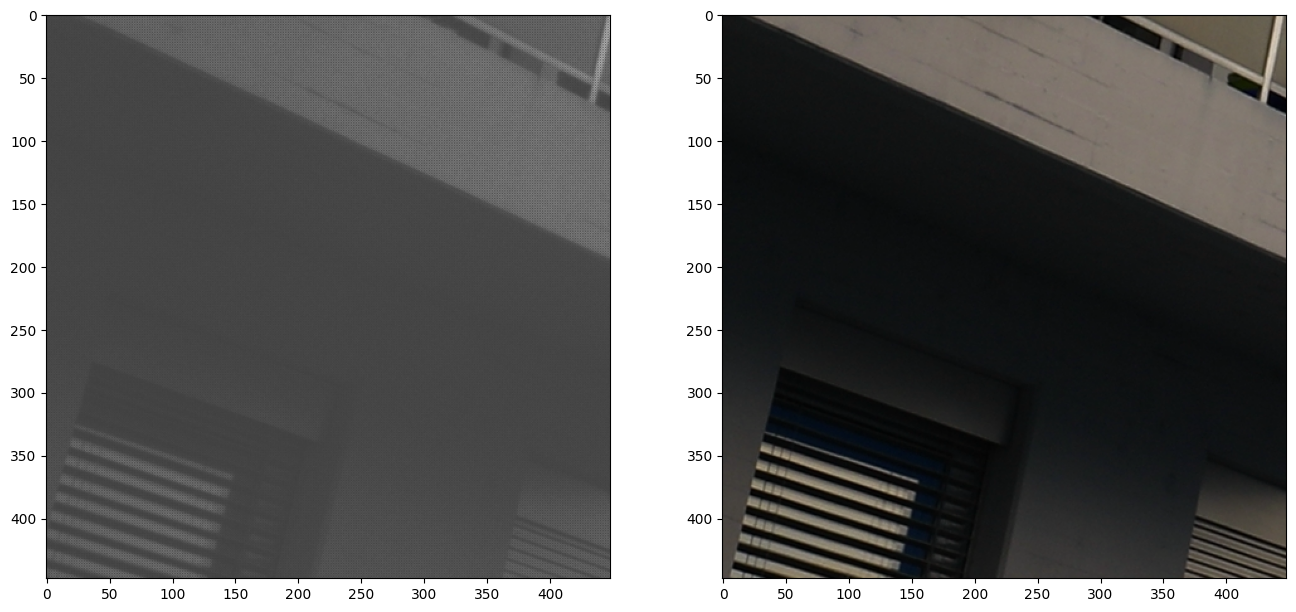

In [50]:
# ! ls ../Zurich-RAW-to-DSLR/train/huawei_raw/
import cv2
import matplotlib.pyplot as plt
import numpy as np

index = 9000
im_raw = cv2.imread(f'../Zurich-RAW-to-DSLR/train/huawei_raw/{index}.png')
im_proc = cv2.imread(f'../Zurich-RAW-to-DSLR/train/canon/{index}.jpg')

print(im_raw.shape)
print(im_proc.shape)

plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(im_raw)

plt.subplot(1, 2, 2)
plt.imshow(im_proc)
plt.show()

In [60]:
index = 9000
im_raw = cv2.imread(f'../Zurich-RAW-to-DSLR/train/huawei_raw/{index}.png')
im_proc = cv2.imread(f'../Zurich-RAW-to-DSLR/train/canon/{index}.jpg')

print(np.sum(im_raw[:, :, 0]))
print(np.sum(im_raw[:, :, 1]))
print(np.sum(im_raw[:, :, 2]))

print()
print(np.sum(im_proc[:, :, 0]))
print(np.sum(im_proc[:, :, 1]))
print(np.sum(im_proc[:, :, 2]))

15697326
15697326
15697326

9006443
8821215
8398298


In [ ]:
index = 9000

# 1. read H×W×C (uint8, BGR) → convert to RGB float32
im_raw = cv2.imread(f'../Zurich-RAW-to-DSLR/train/huawei_raw/{index}.png', cv2.IMREAD_UNCHANGED)
im_raw = cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB).astype('float32') / 255.0

# 2. H×W×C → torch, add batch
im_raw = torch.from_numpy(im_raw)          # (H, W, 3)
im_raw = im_raw.unsqueeze(0)               # (1, H, W, 3)

# 3. reorder to NCHW
im_raw = im_raw.permute(0, 3, 1, 2)        # (1, 3, H, W)

# 4. pad a zero channel to make 4 channels
zeros = torch.zeros_like(im_raw[:, :1, :, :])  
im_raw = torch.cat((im_raw, zeros), dim=1)  # (1, 4, H, W)

print(im_raw.shape)  

# model.eval()  
# with torch.no_grad():
#     out = model(im_raw) 

_, _, H, W = im_raw.shape
coord_dummy = torch.zeros((1, 2, H, W), device=im_raw.device)

with torch.no_grad():
    out = model(im_raw, coord=coord_dummy)


img = out[0].permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)

plt.figure()
plt.imshow(img.clip(0, 1))  # assuming values are in [0,1]
plt.axis('off')
plt.show()
# im_raw

torch.Size([1, 4, 448, 448])


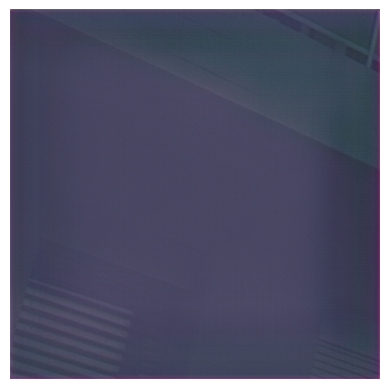

In [70]:
img = out[0].permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)

plt.figure()
plt.imshow(img.clip(0, 1))  # assuming values are in [0,1]
plt.axis('off')
plt.show()

#### This is how the raw images are read from the disk

In [ ]:
# in class ZRRDataset
# self.coord = get_coord(H=448, W=448, x=1, y=1)
def get_coord(H, W, x=448/3968, y=448/2976):
    x_coord = np.linspace(-x + (x / W), x - (x / W), W)
    x_coord = np.expand_dims(x_coord, axis=0)
    x_coord = np.tile(x_coord, (H, 1))
    x_coord = np.expand_dims(x_coord, axis=0)

    y_coord = np.linspace(-y + (y / H), y - (y / H), H)
    y_coord = np.expand_dims(y_coord, axis=1)
    y_coord = np.tile(y_coord, (1, W))
    y_coord = np.expand_dims(y_coord, axis=0)

    coord = np.ascontiguousarray(np.concatenate([x_coord, y_coord]))
    coord = np.float32(coord)

    return coord


"""The cropped images have the shapes 448, 448, 3"""
def _getitem_visual(self, idx):
		# raw_combined is the thing fed into the liteisp model
        # is has the shape 4, 224, 224  raw_images[idx] has the shape [448, 448]
                                # in the code raw_images[idx] = cv2.imread(path)[-1] (each raw image has 3 exact same replicas)             
        raw_combined, raw_demosaic = self._process_raw(self.raw_images[idx])
        h, w = raw_demosaic.shape[-2:]
        coord = get_coord(H=h, W=w, x=1, y=1)

        return {'raw': raw_combined, # shape = 4, 224, 224
				'raw_demosaic': raw_demosaic,
				'dslr': raw_combined,
				'coord': coord,
				'fname': self.names[idx]}

def remove_black_level(img, black_lv=63, white_lv=4*255):
    img = np.maximum(img.astype(np.float32)-black_lv, 0) / (white_lv-black_lv)
    return img

def extract_bayer_channels(raw):  # HxW
    ch_R  = raw[0::2, 0::2]
    ch_Gb = raw[0::2, 1::2]
    ch_Gr = raw[1::2, 0::2]
    ch_B  = raw[1::2, 1::2]
    raw_combined = np.dstack((ch_B, ch_Gb, ch_R, ch_Gr))
    raw_combined = np.ascontiguousarray(raw_combined.transpose((2, 0, 1)))
    return raw_combined  # 4xHxW

def _process_raw(self, raw):
    raw = remove_black_level(raw)
    raw_combined = extract_bayer_channels(raw)
    raw_demosaic = get_raw_demosaic(raw)
    return raw_combined, raw_demosaic
    #         ^^^^^^^ the input to liteisp model of shape [4, 224, 224]

def set_input(self, input):
    self.data_raw = input['raw'].to(self.device) # <- this is the data_raw used by the model below
    self.data_raw_demosaic = input['raw_demosaic'].to(self.device)
    self.data_dslr = input['dslr'].to(self.device)
    self.data_gcm_coord = input['coord'].to(self.device)
    self.image_paths = input['fname']
        
    
self = 'hi'

# now for preparation of the self.data_ispnet_coord[index]
# we do this
def get_coord(H, W, x=448/3968, y=448/2976):
    x_coord = np.linspace(-x + (x / W), x - (x / W), W)
    x_coord = np.expand_dims(x_coord, axis=0)
    x_coord = np.tile(x_coord, (H, 1))
    x_coord = np.expand_dims(x_coord, axis=0)

    y_coord = np.linspace(-y + (y / H), y - (y / H), H)
    y_coord = np.expand_dims(y_coord, axis=1)
    y_coord = np.tile(y_coord, (1, W))
    y_coord = np.expand_dims(y_coord, axis=0)

    coord = np.ascontiguousarray(np.concatenate([x_coord, y_coord]))
    coord = np.float32(coord)

    return coord
# H = 224, W = 224
data_ispnet_coord = get_coord(H=H, W=W, x=1, y=1) # data_ispnet_coord.shape = (2, 224, 224)
data_ispnet_coord = np.expand_dims(data_ispnet_coord, axis=0) # data_ispnet_coord.shape = (1, 2, 224, 224)
data_ispnet_coord = np.tile(data_ispnet_coord, (N, 1, 1, 1)) # still (1, 2, 224, 224)
self.data_ispnet_coord[index] = torch.from_numpy(data_ispnet_coord).to(self.data_raw.device) # conversion of numpy to torch tensor

# then we pass both the raw and data_ispnet_coord to the model


# here is what their shapes look like

# self.data_ispnet_coord[index].shape
# torch.Size([1, 2, 224, 224])
# self.data_raw.shape
# torch.Size([1, 4, 224, 224])

self.data_out = self.netLiteISPNet(self.data_raw, self.data_ispnet_coord[index]) # important, this shows how the data is actually fed into the model


raw_t.shape: torch.Size([1, 4, 224, 224])
coord_t.shape: torch.Size([1, 2, 224, 224])


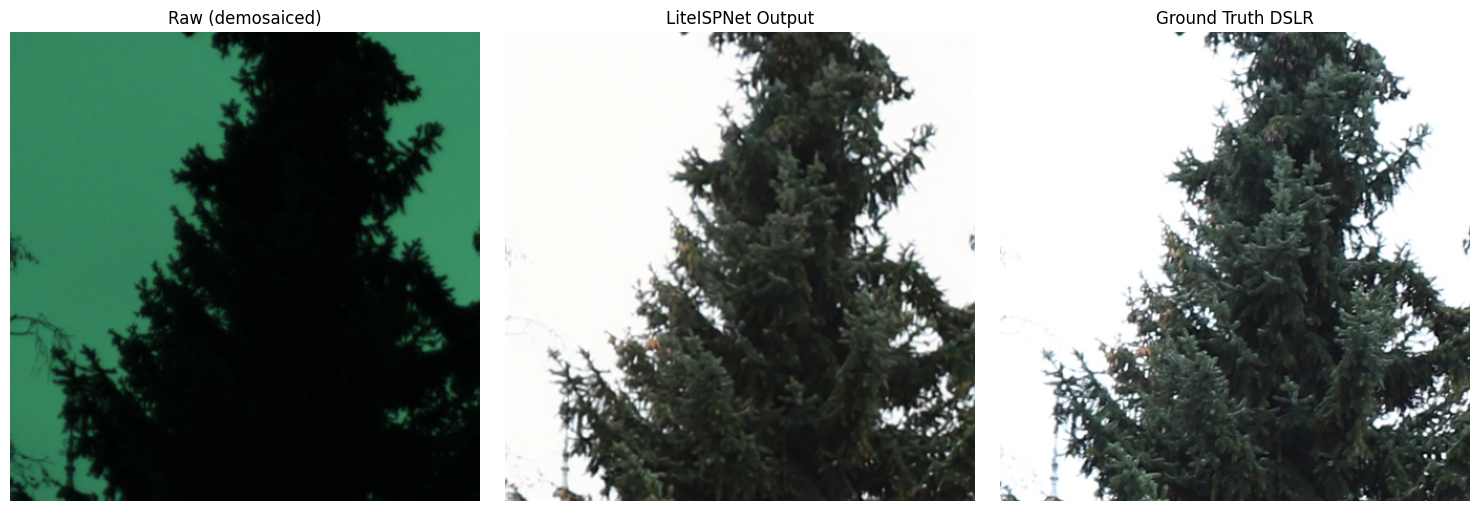

In [4]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def remove_black_level(img, black_lv=63, white_lv=4*255):
    img = np.maximum(img.astype(np.float32) - black_lv, 0)
    return img / (white_lv - black_lv)

def extract_bayer_channels(raw):
    ch_R  = raw[0::2, 0::2]
    ch_Gb = raw[0::2, 1::2]
    ch_Gr = raw[1::2, 0::2]
    ch_B  = raw[1::2, 1::2]
    raw_combined = np.stack((ch_B, ch_Gb, ch_R, ch_Gr), axis=2)
    return np.ascontiguousarray(raw_combined.transpose(2,0,1))

def get_coord(H, W, x=1, y=1):
    xs = np.linspace(-x + x/W, x - x/W, W, dtype=np.float32)
    ys = np.linspace(-y + y/H, y - y/H, H, dtype=np.float32)
    x_grid = np.repeat(xs[np.newaxis, :], H, axis=0)
    y_grid = np.repeat(ys[:, np.newaxis], W, axis=1)
    return np.stack((x_grid, y_grid), axis=0)

def run_liteisp_on_raw(model, raw_png_path, device='cpu'):
    model.to(device).eval()
    raw = cv2.imread(raw_png_path, cv2.IMREAD_UNCHANGED)
    if raw is None:
        raise FileNotFoundError(f"Can't read {raw_png_path}")
    if raw.ndim == 3:
        raw = raw[..., 0]
    raw_norm = remove_black_level(raw)
    raw_combined = extract_bayer_channels(raw_norm)
    _, H, W = raw_combined.shape
    coord_t = torch.from_numpy(get_coord(H, W)).unsqueeze(0).to(device)
    raw_t   = torch.from_numpy(raw_combined).unsqueeze(0).to(device)
    print(f'raw_t.shape: {raw_t.shape}')
    print(f'coord_t.shape: {coord_t.shape}')
    with torch.no_grad():
        out_t = model(raw_t, coord_t)
    out_np = out_t[0].permute(1,2,0).cpu().numpy()
    return np.clip(out_np,0,1), raw_norm

# — Load model once —
model = LiteISPNet()
checkpoint = torch.load('ckpt/zrrjoint/LiteISPNet_model_1.pth', map_location='cpu')
model.load_state_dict(checkpoint['state_dict'])

# — File paths —
index = 1298
raw_path = f'../Zurich-RAW-to-DSLR/train/huawei_raw/{index}.png'
gt_path  = f'../Zurich-RAW-to-DSLR/train/canon/{index}.jpg'

# — Run model & prep visuals —
processed_img, raw_norm = run_liteisp_on_raw(model, raw_path)
raw_rgb = cv2.cvtColor((raw_norm * 255).astype(np.uint8),
                       cv2.COLOR_BAYER_BG2RGB) / 255.0
gt_bgr = cv2.imread(gt_path, cv2.IMREAD_COLOR)
gt_rgb = cv2.cvtColor(gt_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

# — Plot all three —
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title('Raw (demosaiced)')
plt.imshow(raw_rgb)
plt.axis('off')

plt.subplot(1,3,2)
plt.title('LiteISPNet Output')
plt.imshow(processed_img)
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Ground Truth DSLR')
plt.imshow(gt_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Utilities
def remove_black_level(img, black_lv=63, white_lv=4*255):
    img = np.maximum(img.astype(np.float32) - black_lv, 0)
    return img / (white_lv - black_lv)

def extract_bayer_channels(raw):
    ch_R  = raw[0::2, 0::2]
    ch_Gb = raw[0::2, 1::2]
    ch_Gr = raw[1::2, 0::2]
    ch_B  = raw[1::2, 1::2]
    raw_combined = np.stack((ch_B, ch_Gb, ch_R, ch_Gr), axis=2)
    return np.ascontiguousarray(raw_combined.transpose(2,0,1))

def get_coord(H, W, x=1, y=1):
    xs = np.linspace(-x + x/W, x - x/W, W, dtype=np.float32)
    ys = np.linspace(-y + y/H, y - y/H, H, dtype=np.float32)
    x_grid = np.repeat(xs[np.newaxis, :], H, axis=0)
    y_grid = np.repeat(ys[:, np.newaxis], W, axis=1)
    return np.stack((x_grid, y_grid), axis=0)

# Core inference for a single raw image or full-res padded image
def run_liteisp_on_raw(model, raw_png_path=None, raw_array=None, device='cpu'):
    model.to(device).eval()
    if raw_array is None:
        raw = cv2.imread(raw_png_path, cv2.IMREAD_UNCHANGED)
        if raw is None:
            raise FileNotFoundError(f"Can't read {raw_png_path}")
    else:
        raw = raw_array
    if raw.ndim == 3:
        raw = raw[..., 0]
    raw_norm = remove_black_level(raw)
    raw_combined = extract_bayer_channels(raw_norm)
    _, H, W = raw_combined.shape
    coord_t = torch.from_numpy(get_coord(H, W)).unsqueeze(0).to(device)
    raw_t   = torch.from_numpy(raw_combined).unsqueeze(0).to(device)
    with torch.no_grad():
        out_t = model(raw_t, coord_t)
    out_np = out_t[0].permute(1,2,0).cpu().numpy()
    return np.clip(out_np,0,1), raw_norm

# Plotting function
def plot_comparison(raw_norm, processed_img, gt_path):
    raw_rgb = cv2.cvtColor((raw_norm * 255).astype(np.uint8), cv2.COLOR_BAYER_BG2RGB) / 255.0
    gt_bgr = cv2.imread(gt_path, cv2.IMREAD_COLOR)
    if gt_bgr is None:
        raise FileNotFoundError(f"Can't read {gt_path}")
    gt_rgb = cv2.cvtColor(gt_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    plt.figure(figsize=(15,5))
    for i, (img, title) in enumerate([
        (raw_rgb, 'Raw (demosaiced)'),
        (processed_img, 'LiteISPNet Output'),
        (gt_rgb, 'Ground Truth DSLR')
    ], 1):
        plt.subplot(1,3,i)
        plt.title(title)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Full-resolution single-pass inference with padding to multiples of 8

def run_full_resolution_single_pass(model, index, raw_dir, gt_dir, device='cpu'):  
    raw_path = f"{raw_dir}/{index}.jpg"
    gt_path  = f"{gt_dir}/{index}.jpg"
    full_raw = cv2.imread(raw_path, cv2.IMREAD_UNCHANGED)
    if full_raw is None:
        raise FileNotFoundError(f"Can't read {raw_path}")
    if full_raw.ndim == 3:
        full_raw = full_raw[..., 0]

    H, W = full_raw.shape
    # compute padded sizes
    H_pad = ((H + 7) // 8) * 8
    W_pad = ((W + 7) // 8) * 8
    pad_bottom = H_pad - H
    pad_right  = W_pad - W

    # pad raw image
    full_raw_padded = np.pad(full_raw, ((0, pad_bottom), (0, pad_right)), mode='constant', constant_values=0)

    # run model on padded full image
    output_padded, raw_norm_padded = run_liteisp_on_raw(model, raw_array=full_raw_padded, device=device)

    # crop back to original size
    output_full = output_padded[:H, :W, :]
    raw_norm = raw_norm_padded[:H, :W]
    return output_full, raw_norm, gt_path

# Example usage
if __name__ == '__main__':
    model = LiteISPNet()
    ckpt = torch.load('ckpt/zrrjoint/LiteISPNet_model_1.pth', map_location='cpu')
    model.load_state_dict(ckpt['state_dict'])

    idx = 21
    # single patch run
    # proc, raw_norm = run_liteisp_on_raw(model, raw_png_path=f'../Zurich-RAW-to-DSLR/train/huawei_raw/{idx}.png')
    # plot_comparison(raw_norm, proc, f'../Zurich-RAW-to-DSLR/train/canon/{idx}.jpg')

    # full-res single-pass run
    raw_full_dir = '../Zurich-RAW-to-DSLR/full_resolution/huawei_isp'
    gt_full_dir  = '../Zurich-RAW-to-DSLR/full_resolution/canon'
    full_out, full_raw_norm, full_gt = run_full_resolution_single_pass(
        model, idx, raw_full_dir, gt_full_dir, device='cpu')
    plot_comparison(full_raw_norm, full_out, full_gt)


In [9]:
! ls ../Zurich-RAW-to-DSLR/full_resolution/huawei_isp/ | grep 21

2108.jpg
2129.jpg
2150.jpg
2169.jpg
21.jpg
4213.jpg


In [ ]:
# torch.rand(1, 4, 224, 224).shape
shape = 344
integer = 5
out = model(torch.rand(1, 4, shape*integer, shape), torch.rand(1, 2, shape*integer, shape))
print(out.shape)

ckpt	     losses.py	 networks.py  README.md        test_zrr.sh     util
data	     main.ipynb  options      _temp_patch.png  train.py
figs	     metrics.py  pwc	      test.py	       train_srraw.sh
launch.json  models	 __pycache__  test_srraw.sh    train_zrr.sh


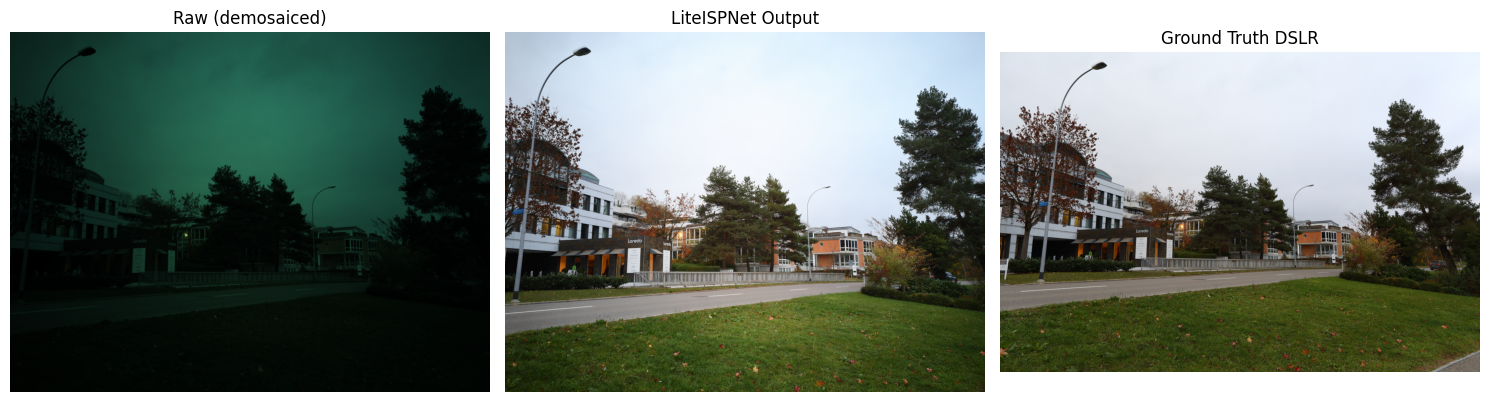

In [10]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Utilities
def remove_black_level(img, black_lv=63, white_lv=4*255):
    img = np.maximum(img.astype(np.float32) - black_lv, 0)
    return img / (white_lv - black_lv)

def extract_bayer_channels(raw):
    ch_R  = raw[0::2, 0::2]
    ch_Gb = raw[0::2, 1::2]
    ch_Gr = raw[1::2, 0::2]
    ch_B  = raw[1::2, 1::2]
    raw_combined = np.stack((ch_B, ch_Gb, ch_R, ch_Gr), axis=2)
    return np.ascontiguousarray(raw_combined.transpose(2,0,1))

def get_coord(H, W, x=1, y=1):
    xs = np.linspace(-x + x/W, x - x/W, W, dtype=np.float32)
    ys = np.linspace(-y + y/H, y - y/H, H, dtype=np.float32)
    x_grid = np.repeat(xs[np.newaxis, :], H, axis=0)
    y_grid = np.repeat(ys[:, np.newaxis], W, axis=1)
    return np.stack((x_grid, y_grid), axis=0)

# Core inference for a single raw image or full-res padded image
def run_liteisp_on_raw(model, raw_png_path=None, raw_array=None, device='cpu'):
    model.to(device).eval()
    if raw_array is None:
        raw = cv2.imread(raw_png_path, cv2.IMREAD_UNCHANGED)
        if raw is None:
            raise FileNotFoundError(f"Can't read {raw_png_path}")
    else:
        raw = raw_array
    if raw.ndim == 3:
        raw = raw[..., 0]
    raw_norm = remove_black_level(raw)
    raw_combined = extract_bayer_channels(raw_norm)
    _, H, W = raw_combined.shape
    coord_t = torch.from_numpy(get_coord(H, W)).unsqueeze(0).to(device)
    raw_t   = torch.from_numpy(raw_combined).unsqueeze(0).to(device)
    with torch.no_grad():
        out_t = model(raw_t, coord_t)
    out_np = out_t[0].permute(1,2,0).cpu().numpy()
    return np.clip(out_np,0,1), raw_norm

# Plotting function
def plot_comparison(raw_norm, processed_img, gt_path):
    raw_rgb = cv2.cvtColor((raw_norm * 255).astype(np.uint8), cv2.COLOR_BAYER_BG2RGB) / 255.0
    gt_bgr = cv2.imread(gt_path, cv2.IMREAD_COLOR)
    if gt_bgr is None:
        raise FileNotFoundError(f"Can't read {gt_path}")
    gt_rgb = cv2.cvtColor(gt_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    plt.figure(figsize=(15,5))
    for i, (img, title) in enumerate([
        (raw_rgb, 'Raw (demosaiced)'),
        (processed_img, 'LiteISPNet Output'),
        (gt_rgb, 'Ground Truth DSLR')
    ], 1):
        plt.subplot(1,3,i)
        plt.title(title)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Full-resolution single-pass inference with padding to multiples of 8

def run_full_resolution_single_pass(model, index, raw_dir, gt_dir, device='cpu'):  
    raw_path = f"{raw_dir}/{index}.png"
    gt_path  = f"{gt_dir}/{index}.jpg"
    full_raw = cv2.imread(raw_path, cv2.IMREAD_UNCHANGED)
    if full_raw is None:
        raise FileNotFoundError(f"Can't read {raw_path}")
    if full_raw.ndim == 3:
        full_raw = full_raw[..., 0]

    H, W = full_raw.shape
    # compute padded sizes
    H_pad = ((H + 7) // 8) * 8
    W_pad = ((W + 7) // 8) * 8
    pad_bottom = H_pad - H
    pad_right  = W_pad - W

    # pad raw image
    full_raw_padded = np.pad(full_raw, ((0, pad_bottom), (0, pad_right)), mode='constant', constant_values=0)

    # run model on padded full image
    output_padded, raw_norm_padded = run_liteisp_on_raw(model, raw_array=full_raw_padded, device=device)

    # crop back to original size
    output_full = output_padded[:H, :W, :]
    raw_norm = raw_norm_padded[:H, :W]
    return output_full, raw_norm, gt_path

# Example usage
if __name__ == '__main__':
    model = LiteISPNet()
    ckpt = torch.load('ckpt/zrrjoint/LiteISPNet_model_1.pth', map_location='cpu')
    model.load_state_dict(ckpt['state_dict'])

    idx = 244
    # single patch run
    # proc, raw_norm = run_liteisp_on_raw(model, raw_png_path=f'../Zurich-RAW-to-DSLR/train/huawei_raw/{idx}.png')
    # plot_comparison(raw_norm, proc, f'../Zurich-RAW-to-DSLR/train/canon/{idx}.jpg')

    # full-res single-pass run
    raw_full_dir = '../Zurich-RAW-to-DSLR/full_resolution/huawei_raw'
    gt_full_dir  = '../Zurich-RAW-to-DSLR/full_resolution/canon'
    full_out, full_raw_norm, full_gt = run_full_resolution_single_pass(
        model, idx, raw_full_dir, gt_full_dir, device='cpu')
    plot_comparison(full_raw_norm, full_out, full_gt)
